In [1]:
import os
import socket
from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql import types as T, functions as F, SparkSession
from pyspark.sql.window import Window
from pyspark import StorageLevel
from jinja2 import Environment, FileSystemLoader
import datetime
import json
from pyspark.sql.functions import when

In [2]:
LOGIN = "irubin-370046"  # Your gateway.st login
APP_NAME = "ML"  # Any name for your Spark-app

In [3]:
NORMALIZED_APP_NAME = APP_NAME.replace('/', '_').replace(':', '_').replace(' ', '_').replace('\\', '_')

APPS_TMP_DIR = os.path.join(os.getcwd(), "tmp")
APPS_CONF_DIR = os.path.join(os.getcwd(), "conf")
APPS_LOGS_DIR = os.path.join(os.getcwd(), "logs")
LOG4J_PROP_FILE = os.path.join(APPS_CONF_DIR, "pyspark-log4j-{}.properties".format(NORMALIZED_APP_NAME))
LOG_FILE = os.path.join(APPS_LOGS_DIR, 'pyspark-{}.log'.format(NORMALIZED_APP_NAME))
EXTRA_JAVA_OPTIONS = (
    "-Dlog4j.configuration=file://{} "
    "-Dspark.hadoop.dfs.replication=1 "
    "-Dhttps.protocols=TLSv1.0,TLSv1.1,TLSv1.2,TLSv1.3"
    .format(LOG4J_PROP_FILE)
)

LOCAL_IP = socket.gethostbyname(socket.gethostname())

In [4]:
for directory in [APPS_CONF_DIR, APPS_LOGS_DIR, APPS_TMP_DIR]:
    if not os.path.exists(directory):
        os.makedirs(directory)

env = Environment(loader=FileSystemLoader('/opt'))
template = env.get_template("pyspark_log4j.properties.template")
template.stream(logfile=LOG_FILE).dump(LOG4J_PROP_FILE)

In [5]:
spark = (
    SparkSession
    .builder
    .appName(APP_NAME)
    
    # Master URI/configuration
    .master("k8s://https://10.32.7.103:6443")
    
    .config("spark.driver.host", LOCAL_IP)
    
    # Web-UI port for your Spark-app
    .config("spark.ui.port", "4040")
    .config("spark.driver.bindAddress", "0.0.0.0")
    
    # How many CPU cores allocate to driver process
    .config("spark.driver.cores", "2")
    
    # How many RAM allocate to driver process
    .config("spark.driver.memory", "6g")
    
    # How many executors to create
    .config("spark.executor.instances", "3")
    
    # How many CPU cores allocate to each executor
    .config("spark.executor.cores", '2')
    
    # How many RAM allocate to each executor
    .config("spark.executor.memory", "6g")
    
    # How many extra RAM allocate to each executor pod to handle with JVM overheads
    # Total pod RAM = 'spark.executor.memory' + ('spark.executor.memory' * 'spark.kubernetes.memoryOverheadFactor')
    .config("spark.kubernetes.memoryOverheadFactor", "0.2")
    
    # How many RAM from the pool allocate to store the data
    # Additional info: https://spark.apache.org/docs/latest/tuning.html#memory-management-overview
    .config("spark.memory.fraction", "0.6")
    .config("spark.memory.storageFraction", "0.5")
    
    .config("spark.network.timeout", "180s")
    .config("spark.sql.autoBroadcastJoinThreshold", "-1")
    .config("spark.driver.extraJavaOptions", EXTRA_JAVA_OPTIONS)
    
    # Namespace to create executor pods. You are allowed to create pods only in your own namespace
    .config("spark.kubernetes.namespace", LOGIN)
    
    # Extra labels to your driver/executor pods in Kubernetes
    .config("spark.kubernetes.driver.label.appname", APP_NAME)
    .config("spark.kubernetes.executor.label.appname", APP_NAME)
    
    # Spark executor image
    .config("spark.kubernetes.container.image", f"node03.st:5000/spark-executor:{LOGIN}")

    .config("spark.kubernetes.container.image.pullPolicy", "Always")
    
    # If true - delete completed/failed pods. 
    # If your executors goes down you can set 'false' to check logs and troubleshoot your app.
    .config("spark.kubernetes.executor.deleteOnTermination", "true")
    
    .config("spark.local.dir", "/tmp/spark")
    .getOrCreate()
)

In [10]:
spark.stop()

In [6]:
DATA_PATH = "hdfs:///home/irubin-370046"

In [7]:
df = spark.read.json(f"{DATA_PATH}/final_df.json")

In [8]:
df = df.withColumn("Year", \
              when(df.Year == 2007, 1)\
                  .when(df.Year == 2008, 2)\
                  .when(df.Year == 2009, 3)\
                  .when(df.Year == 2010, 4)\
                 .when(df.Year == 2011, 5)\
                  .when(df.Year == 2012, 6)\
                  .when(df.Year == 2013, 7)\
                  .when(df.Year == 2014, 8)\
                  .when(df.Year == 2015, 9)\
                .when(df.Year == 2016, 10)\
                  .when(df.Year == 2017, 11)\
                  .when(df.Year == 2018, 12)\
                  .when(df.Year == 2019, 13)\
                  .when(df.Year == 2020, 14)\
                  .when(df.Year == 2021, 15)\
                  .when(df.Year == 2022, 16)\
                  .when(df.Year == 2023, 17)\
                   .when(df.Year == 2006, 0)\
                   .otherwise(df.Year)
                  )

In [9]:
from pyspark.sql.types import LongType
df = df.withColumn("Year", df["Year"].cast(LongType()))

In [10]:
# This features need one-hot encoding


# This features need mapping from True/False values to 0/1 (just cast integer)
need_map = ['caption', 
            'description_has_links', 
            'description_has_tags',
            'emoji_in_title',
            'has_description',
            'has_pop_tags',
            'has_tags',
            'licensedContent',
            'status',
            'title_has_excl',
            'title_has_tags',
            'title_is_uppercase']

# Definition only has two values (hd, sd) and can be encoded as 0/1
need_map_too = ['definition']

# Need MinMax scaling
need_scaling = ['description_len', 'log_duration', 'mean_popularity', 'title_len', 'Month', 'hour','dayofweek', 'categoryId', 'Year']

In [11]:
for col in need_map:
    df = (df.withColumn(col, df.licensedContent.cast('integer')))

In [12]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

unlist = udf(lambda x: float(list(x)[0]), DoubleType())

for i in need_scaling:
    assembler = VectorAssembler(inputCols=[i], outputCol=i+"_Vect")

    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

    pipeline = Pipeline(stages=[assembler, scaler])

    df = pipeline.fit(df).transform(df).withColumn(i+"_Scaled", unlist(i+"_Scaled")).drop(i+"_Vect")

In [13]:
from pyspark.ml.feature import StringIndexer
str_indexer = StringIndexer(inputCol="definition", outputCol="definition_index")

str_indexer = str_indexer.fit(df)

df = str_indexer.transform(df)

In [ ]:
from pyspark.ml.feature import OneHotEncoder
encoder = OneHotEncoder(inputCols=need_ohe, 
                                 outputCols= [f'{col}_ohe' for col in need_ohe])
encoder = encoder.fit(df)

df = encoder.transform(df)

In [14]:
df.printSchema()

root
 |-- Month: long (nullable = true)
 |-- Year: long (nullable = true)
 |-- caption: integer (nullable = true)
 |-- categoryId: long (nullable = true)
 |-- dayofweek: long (nullable = true)
 |-- definition: string (nullable = true)
 |-- description_has_links: integer (nullable = true)
 |-- description_has_tags: integer (nullable = true)
 |-- description_len: double (nullable = true)
 |-- emoji_in_title: integer (nullable = true)
 |-- has_description: integer (nullable = true)
 |-- has_pop_tags: integer (nullable = true)
 |-- has_tags: integer (nullable = true)
 |-- hour: long (nullable = true)
 |-- licensedContent: integer (nullable = true)
 |-- log_duration: double (nullable = true)
 |-- mean_popularity: double (nullable = true)
 |-- popularity: double (nullable = true)
 |-- status: integer (nullable = true)
 |-- title_has_excl: integer (nullable = true)
 |-- title_has_tags: integer (nullable = true)
 |-- title_is_uppercase: integer (nullable = true)
 |-- title_len: long (nullable 

In [15]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = [  'caption',
                                                
                                                 'description_has_links',
                                                 'description_has_tags',
                                                 'description_len',
                                                 'emoji_in_title',
                                                 'has_description',
                                                 'has_pop_tags',
                                                 'has_tags',
                                                 'licensedContent',
                                                 'status',
                                                 'title_has_excl',
                                                 'title_has_tags',
                                                 'title_is_uppercase',
                                                 'title_len',
                                                 'description_len_Scaled',
                                                 'log_duration_Scaled',
                                                 'title_len_Scaled',
                                                 'Month_Scaled',
                                                 'hour_Scaled',
                                                 'definition_index',
                                                 'dayofweek_Scaled',
                                                 'categoryId_Scaled',
                                                 'Year_Scaled'], outputCol = 'features')
v_df = vectorAssembler.transform(df)
v_df = v_df.select(['features', 'popularity'])
v_df.show(3)

+--------------------+------------------+
|            features|        popularity|
+--------------------+------------------+
|[1.0,1.0,1.0,5.74...|1.5665938388561083|
|[1.0,1.0,1.0,5.37...|1.2711286086456879|
|[1.0,1.0,1.0,6.96...|1.4217195964321903|
+--------------------+------------------+
only showing top 3 rows



In [16]:
train, test = v_df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 2406736
Test Dataset Count: 1031821


## GBT

In [77]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'popularity', maxDepth=10, maxIter=100)

gbt_model = gbt.fit(train)
gbt_predictions = gbt_model.transform(test)
gbt_predictions.select('prediction', 'popularity', 'features').show(5)


+-------------------+-------------------+--------------------+
|         prediction|         popularity|            features|
+-------------------+-------------------+--------------------+
|  0.581303413600299| 0.6981107644785808|(23,[3,13,14,15,1...|
| 0.1259568076388692|0.09879839543056498|(23,[3,13,14,15,1...|
|0.22370923938794843| 0.3265858313135614|(23,[3,13,14,15,1...|
| 0.2036507744738305| 0.3174995691591199|(23,[3,13,14,15,1...|
|0.15535186497119194|0.11866544380791419|(23,[3,13,14,15,1...|
+-------------------+-------------------+--------------------+
only showing top 5 rows



In [78]:
from pyspark.ml.evaluation import RegressionEvaluator
gbt_evaluator = RegressionEvaluator(
    labelCol="popularity", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.307124


In [79]:
featureImp= gbt_model.featureImportances

In [88]:
featureImp

SparseVector(23, {0: 0.0799, 3: 0.1652, 13: 0.0736, 15: 0.1895, 17: 0.0295, 18: 0.0749, 19: 0.0305, 20: 0.0157, 21: 0.2231, 22: 0.1181})

In [80]:
gbt_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="popularity",metricName="r2")
print("R Squared (R2) on test data = %g" % gbt_evaluator.evaluate(gbt_predictions))

R Squared (R2) on test data = 0.565246


In [90]:
cols = [  'caption',
                                                
                                                 'description_has_links',
                                                 'description_has_tags',
                                                 'description_len',
                                                 'emoji_in_title',
                                                 'has_description',
                                                 'has_pop_tags',
                                                 'has_tags',
                                                 'licensedContent',
                                                 'status',
                                                 'title_has_excl',
                                                 'title_has_tags',
                                                 'title_is_uppercase',
                                                 'title_len',
                                                 'description_len_Scaled',
                                                 'log_duration',
                                                 'title_len',
                                                 'Month',
                                                 'hour',
                                                 'definition_index',
                                                 'dayofweek',
                                                 'categoryId',
                                                 'Year']


In [91]:
x=featureImp.toArray()

In [92]:
def add_element(dict, key, value):
    if key not in dict:
        dict[key] = []
    dict[key].append(value)


In [93]:
sloavr={}
for i in range(0,len(cols)):
    e=x[i].item()
    sloavr[cols[i]] = e
    


In [94]:
z= {x:y for x,y in sloavr.items() if y!=0}

In [95]:
z=dict(sorted(z.items(), key=lambda item: item[1]))

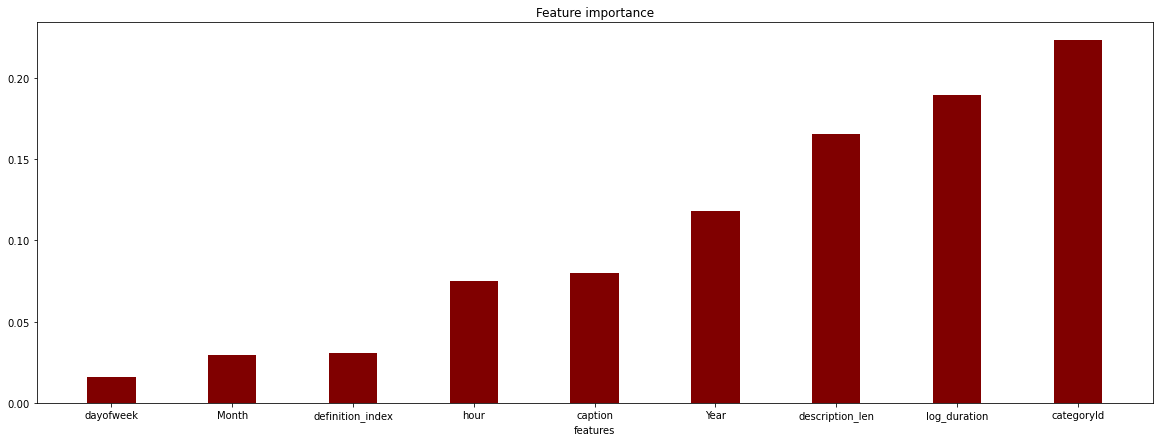

In [96]:
import matplotlib as plt
import matplotlib.pyplot as plt

courses = list(z.keys())
values = list(z.values())
  
fig = plt.figure(figsize = (20,7))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("features")

plt.title("Feature importance")
plt.show()

In [ ]:
####################################################################################

In [47]:
import matplotlib as plt
import matplotlib.pyplot as plt

In [34]:
def calculate_shapley_values(
        df,
        model,
        row_of_interest,
        feature_names,
        features_col='features',
        column_to_examine='anomalyScore'
):
    """
    # Based on the algorithm described here:
    # https://christophm.github.io/interpretable-ml-book/shapley.html#estimating-the-shapley-value
    # And on Baskerville's implementation for IForest/ AnomalyModel here:
    # https://github.com/equalitie/baskerville/blob/develop/src/baskerville/util/model_interpretation/helpers.py#L235
    """
    results = {}
    features_perm_col = 'features_permutations'
    spark = get_spark_session()
    marginal_contribution_filter = F.avg('marginal_contribution').alias(
        'shap_value'
    )
    # broadcast the row of interest and ordered feature names
    ROW_OF_INTEREST_BROADCAST = spark.sparkContext.broadcast(
        row_of_interest[features_col]
    )
    ORDERED_FEATURE_NAMES = spark.sparkContext.broadcast(feature_names)

    # persist before continuing with calculations
    if not df.is_cached:
        df = df.persist()

    # get permutations
    features_df = get_features_permutations(
        df,
        feature_names,
        output_col=features_perm_col
    )

    # set up the udf - x-j and x+j need to be calculated for every row
    def calculate_x(
            feature_j, z_features, curr_feature_perm
    ):
        """
        The instance  x+j is the instance of interest,
        but all values in the order before feature j are
        replaced by feature values from the sample z
        The instance  x−j is the same as  x+j, but in addition
        has feature j replaced by the value for feature j from the sample z
        """
        x_interest = ROW_OF_INTEREST_BROADCAST.value
        ordered_features = ORDERED_FEATURE_NAMES.value
        x_minus_j = list(z_features).copy()
        x_plus_j = list(z_features).copy()
        f_i = curr_feature_perm.index(feature_j)
        after_j = False
        for f in curr_feature_perm[f_i:]:
            # replace z feature values with x of interest feature values
            # iterate features in current permutation until one before j
            # x-j = [z1, z2, ... zj-1, xj, xj+1, ..., xN]
            # we already have zs because we go row by row with the udf,
            # so replace z_features with x of interest
            f_index = ordered_features.index(f)
            new_value = x_interest[f_index]
            x_plus_j[f_index] = new_value
            if after_j:
                x_minus_j[f_index] = new_value
            after_j = True

        # minus must be first because of lag
        return Vectors.dense(x_minus_j), Vectors.dense(x_plus_j)

    udf_calculate_x = F.udf(calculate_x, T.ArrayType(VectorUDT()))

    # persist before processing
    features_df = features_df.persist()

    for f in feature_names:
        # x column contains x-j and x+j in this order.
        # Because lag is calculated this way:
        # F.col('anomalyScore') - (F.col('anomalyScore') one row before)
        # x-j needs to be first in `x` column array so we should have:
        # id1, [x-j row i,  x+j row i]
        # ...
        # that with explode becomes:
        # id1, x-j row i
        # id1, x+j row i
        # ...
        # to give us (x+j - x-j) when we calculate marginal contribution
        # Note that with explode, x-j and x+j for the same row have the same id
        # This gives us the opportunity to use lag with
        # a window partitioned by id
        x_df = features_df.withColumn('x', udf_calculate_x(
            F.lit(f), features_col, features_perm_col
        )).persist()
        print(f'Calculating SHAP values for "{f}"...')
        x_df.show(10, False)
        x_df = x_df.selectExpr(
            'id', f'explode(x) as {features_col}'
        ).cache()
        print('Exploded df:')
        x_df.show(10, False)
        x_df = model.transform(x_df)

        # marginal contribution is calculated using a window and a lag of 1.
        # the window is partitioned by id because x+j and x-j for the same row
        # will have the same id
        x_df = x_df.withColumn(
            'marginal_contribution',
            (
                    F.col(column_to_examine) - F.lag(
                        F.col(column_to_examine), 1
                    ).over(Window.partitionBy('id').orderBy('id')
            )
            )
        )
        x_df.show(5, False)
        # calculate the average
        x_df = x_df.filter(
            x_df.marginal_contribution.isNotNull()
        )
        tdf = x_df.select(
            marginal_contribution_filter
        )
        tdf.show()
        results[f] = x_df.select(
            marginal_contribution_filter
        ).first().shap_value
        x_df.unpersist()
        del x_df
        print(f'Marginal Contribution for feature: {f} = {results[f]} ')

    ordered_results = sorted(
        results.items(),
        key=operator.itemgetter(1),
        reverse=True
    )
    return ordered_results


def shapley_values_for_model(
        model_path,
        feature_names,
        row_id,
        data_path=None,
        column_to_examine=None
):
    from baskerville.spark import get_spark_session
    _ = get_spark_session()
    metadata = get_model_metadata(model_path)
    model = load_model(model_path, metadata)
    features_col = metadata['paramMap'].get('featuresCol', 'features')
    # get sample dataset
    df = load_df_from_json(data_path)
    if 'id' not in df.columns:
        # not a good idea
        warnings.warn('Missing column "id", using monotonically_increasing_id')
        df = df.withColumn('id', F.monotonically_increasing_id())
    df.show(10, False)

    # predict on the data if the df does not contain the results
    if column_to_examine not in df.columns:
        pred_df = model.predict(df)
        df = pred_df.select('id', features_col, column_to_examine)

    # select the row to be examined
    df = select_row(df, row_id)
    row_of_interest = df.select('id', 'features').where(
        F.col('is_selected') == True  # noqa
    ).first()
    print('Row: ', row_of_interest)

    # remove x and drop column_to_examine column
    df = df.select('*').where(
        F.col('is_selected') == False  # noqa
    ).drop(column_to_examine)

    shap_values = calculate_shapley_values(
        df,
        model,
        row_of_interest,
        feature_names,
        features_col=features_col,
        column_to_examine=column_to_examine,
    )
    print('Feature ranking by Shapley values:')
    print('-' * 20)
    print(*[f'#{i}. {feat} = {value}' for i, (feat, value) in
            enumerate(shap_values)])
    return shap_values

In [40]:
calculate_shapley_values(
        v_df,
        dt_model,
        0,
        cols,
        features_col='features',
        column_to_examine='popularity')

NameError: name 'get_spark_session' is not defined

In [41]:
import shap

ModuleNotFoundError: No module named 'shap'